# Evoluation d'une population (correction)

Evolution d'une population à partir des tables de mortalités et d'une situation initiale.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

### Exercice 1 : pyramides des âges

[comment]: <> (RST: .. index:: pyramide des âges, population pyramid)

In [3]:
from actuariat_python.data import population_france_year
population = population_france_year()
df = population
df.head(n=3)

,naissance,age,hommes,femmes,ensemble
0,2019,0,360058,346324,706382
1,2018,1,365656,350503,716159
2,2017,2,371835,357304,729139


In [4]:
hommes = df["hommes"]
femmes = df["femmes"]
somme = hommes - femmes

Je reprends ici le code exposé à [Damien Vergnaud's Homepage](http://www.di.ens.fr/~vergnaud/teaching1415/TPc_20150304_Python.html) en l'adaptant un peu avec les fonctions de matplotlib via l'interface [pyplot](http://matplotlib.org/api/pyplot_api.html). Puis j'ajoute la différence par âge. On commence souvent par la [gallerie](http://matplotlib.org/gallery.html) pour voir si un graphe ou juste une partie est similaire à ce qu'on veut obtenir.

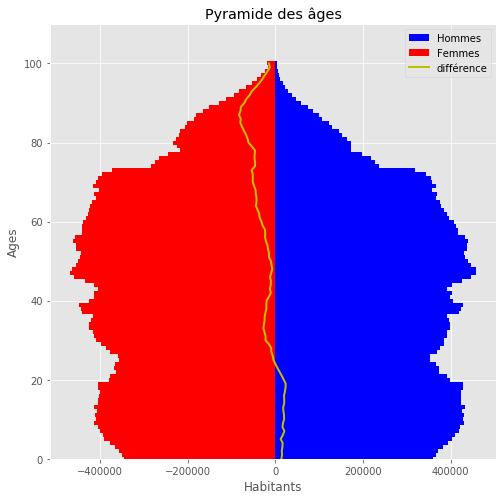

In [5]:
from matplotlib import pyplot as plt
from numpy import arange
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(8,8))
ValH = ax.barh(arange(len(hommes)),hommes,1.0,label="Hommes",color='b',linewidth=0,align='center')
ValF = ax.barh(arange(len(femmes)),-femmes,1.0,label="Femmes",color='r',linewidth=0,align='center')
diff, = ax.plot(somme,arange(len(femmes)),'y',linewidth=2)
ax.set_title("Pyramide des âges")
ax.set_ylabel("Ages")
ax.set_xlabel("Habitants")
ax.set_ylim([0,110])
ax.legend((ValH[0], ValF[0], diff), ('Hommes', 'Femmes', 'différence'));

Le même en utilisant la fonction insérée dans le module [actuariat_python](http://www.xavierdupre.fr/app/actuariat_python/helpsphinx/index.html).

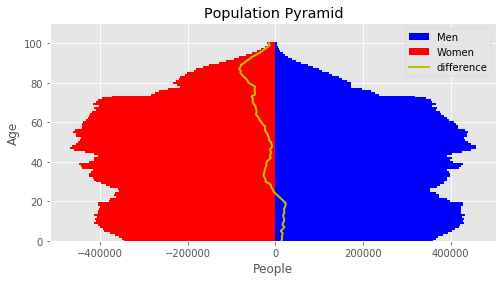

In [6]:
from actuariat_python.plots import plot_population_pyramid
plot_population_pyramid(df["hommes"], df["femmes"], figsize=(8, 4));

### Exercice 2 : calcul de l'espérance de vie

Le premier objectif est de calculer l'[espérance de vie](https://en.wikipedia.org/wiki/Life_expectancy) à l'âge $t$ à partir de la table de mortalité. On récupère cette table.

[comment]: <> (RST: .. index:: table de mortalité, mortality table)

In [7]:
from actuariat_python.data import table_mortalite_france_00_02
df=table_mortalite_france_00_02()
import pandas
pandas.concat([df.head(n=3), df.tail(n=3)])

,Age,Homme,Femme
0,0,100000.0,100000.0
1,1,99511.0,99616.0
2,2,99473.0,99583.0
115,117,0.0,0.0
116,118,0.0,0.0
117,120,0.0,0.0


On note $P_t$ la population l'âge $t$. La probabilité de mourir à la date $t+d$ lorsqu'on a l'âge $t$ correspond à la probabilité de rester en vie à jusqu'à l'âge $t+d$ puis de mourir dans l'année qui suit :

$$m_{t+d} = \frac{P_{t+d}}{P_t}\frac{P_{t+d} - P_{t+d+1}}{P_{t+d}} $$.

L'espérance de vie s'exprime :

$$\mathbb{E}(t) = \sum_{d=1}^\infty d m_{t+d} = \sum_{d=1}^\infty d \frac{P_{t+d}}{P_t}\frac{P_{t+d} - P_{t+d+1}}{P_{t+d}} = \sum_{d=1}^\infty d \frac{P_{t+d} - P_{t+d+1}}{P_{t}} $$

On crée une matrice allant de 0 à 120 ans et on pose $\mathbb{E}(120)=0$. On utilise le module [numpy](http://www.numpy.org/).

In [8]:
import numpy
hf = df[["Homme", "Femme"]].values
hf = numpy.vstack([hf, numpy.zeros((8, 2))])
hf.shape

(126, 2)

In [9]:
nb = hf.shape[0]
esp = numpy.zeros ((nb,2))
for t in range(0,nb):
    for i in (0,1):
        if hf[t,i] == 0:
            esp[t,i] = 0
        else:
            somme  = 0.0
            for d in range(1,nb-t):
                if hf[t+d,i] > 0:
                    somme += d * (hf[t+d,i] - hf[t+d+1,i]) / hf[t,i]
            esp[t,i] = somme
esp[:1]            

array([[75.00752, 82.48832]])

Enfin, on dessine le résultat avec matplotlib :

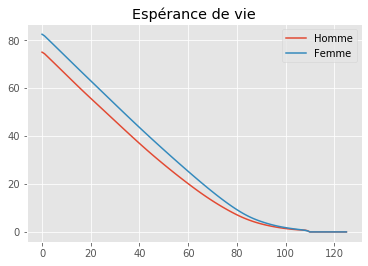

In [10]:
h = plt.plot(esp)
plt.legend(h, ["Homme", "Femme"])
plt.title("Espérance de vie");

Le calcul implémenté ci-dessus n'est pas le plus efficace. On fait deux boucles imbriquées dont le coût global est en $O(n^2)$ mais surtout on effectue les mêmes calculs plusieurs fois. Pour le réduire à un coût linéaire $O(n)$, il faut s'intéresser à la quantité :

$$P_{t+1} \mathbb{E}(t+1) - P_t \mathbb{E}(t) = \sum_{d=1}^\infty d (P_{t+d+1} - P_{t+d+2}) - \sum_{d=1}^\infty d (P_{t+d} - P_{t+d+1})$$

L'implémentation devra utiliser la fonction [numpy.cumsum](http://docs.scipy.org/doc/numpy/reference/generated/numpy.cumsum.html) et cette astuce [Pandas Dataframe cumsum by row in reverse column order?](http://stackoverflow.com/questions/26389959/pandas-dataframe-cumsum-by-row-in-reverse-column-order).

In [11]:
# à suivre

[numpy](http://www.numpy.org/) et [pandas](http://pandas.pydata.org/) ont plusieurs fonction en commun dès qu'il s'agit de parcourir les données. Il existe aussi la fonction [DataFrame.cumsum](http://pandas.pydata.org/pandas-docs/dev/generated/pandas.DataFrame.cumsum.html).

### Exercice 3 : simulation de la pyramide l'année suivante

L'objectif est d'estimer la population française à l'année $T$. Si $P(a,T)$ désigne le nombre de personnes d'âge $a$ en $T$, on peut estimer $P(a,T+1)$ en utilisant la probabilité de mourir $m(a)$ :

$$ P(a+1, T+1) = P(a,T) * (1 - m(a))$$

On commence par calculer les coefficients $m(a)$ avec la table ``hf`` obtenue lors de l'exercice précédent tout en gardant la même dimension (on aura besoin de la fonction [nan_to_num](http://docs.scipy.org/doc/numpy/reference/generated/numpy.nan_to_num.html) :

In [12]:
mortalite = (hf[:-1] - hf[1:]) / hf[:-1]
mortalite = numpy.nan_to_num(mortalite)  # les divisions nulles deviennent nan, on les remplace par 0
mortalite = numpy.vstack([mortalite, numpy.zeros((1, 2))])
m = mortalite

c:\python372_x64\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


La population a été obtenue lors de l'exercice 1, on la convertit en un objet [numpy](http://www.numpy.org/) :

In [13]:
pop = population[["hommes","femmes"]].values
pop = numpy.vstack( [pop, numpy.zeros((m.shape[0] - pop.shape[0], 2))])
pop.shape

(126, 2)

Ensuite on calcule la population en 2020 :

In [14]:
pop_next = pop * (1-m)
pop_next = numpy.vstack([numpy.zeros((1, 2)), pop_next[:-1]])
pop_next[:5]

array([[     0.        ,      0.        ],
       [358297.31638   , 344994.11584   ],
       [365516.36791912, 350386.88814046],
       [371734.07266293, 357228.65195867],
       [382450.37346902, 366544.40263353]])

In [15]:
pop[:5]

array([[360058., 346324.],
       [365656., 350503.],
       [371835., 357304.],
       [382535., 366607.],
       [393693., 377204.]])

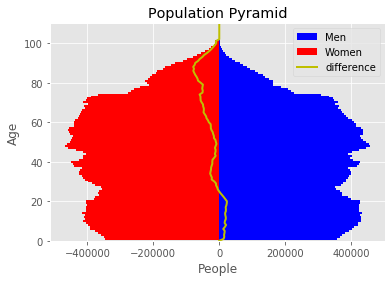

In [16]:
from actuariat_python.plots import plot_population_pyramid
plot_population_pyramid(pop_next[:, 0], pop_next[:, 1]);

### Exercice 4 : simulation jusqu'en 2100

Il s'agit de répéter l'itération effectuée lors de l'exercice précédent. Le plus est de recopier le code dans une fonction et de l'appeler un grand nombre de fois.

[comment]: <> (RST: .. index:: simulation)

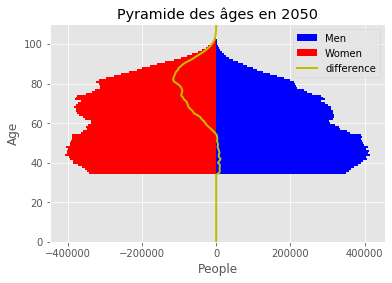

In [17]:
def iteration(pop, mortalite):
    pop_next = pop * (1-mortalite)
    pop_next = numpy.vstack([numpy.zeros((1,2)), pop_next[:-1]]) # aucune naissance
    return pop_next

popt = pop
for year in range(2016, 2051):
    popt = iteration(popt, mortalite)
                             
plot_population_pyramid(popt[:,0], popt[:,1], title="Pyramide des âges en 2050");

### Exercice 5 : simulation avec les naissances

Dans l'exercice précédent, la seconde ligne de la fonction *iteration* correspond à cas où il n'y a pas de naissance. On veut remplacer cette ligne par quelque chose proche de la réalité :

* les naissances sont calculées à partir de la population féminines et de la table de fécondité
* on garde la même proportion homme/femme que celle actuellement observée

In [18]:
ratio = pop[0,0] / (pop[0,1] + pop[0,0])
ratio

0.5097213688910532

Il y a un peu plus de garçons qui naissent chaque année.

In [19]:
from actuariat_python.data import fecondite_france
df = fecondite_france()
df.head()

,age,2005,2015
4,16.0,0.2,0.2
5,17.0,0.5,0.5
6,18.0,1.0,1.1
7,19.0,2.0,2.1
8,20.0,3.0,3.2


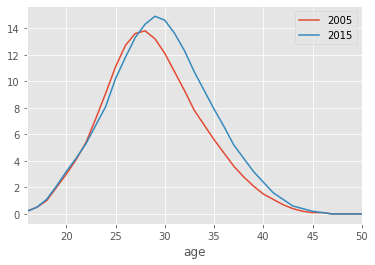

In [20]:
from matplotlib import pyplot as plt
df.plot(x="age", y=["2005","2015"]);

On convertit ces données en une matrice numpy sur 120 lignes comme les précédentes. On se sert des méthodes [fillna](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) et [merge](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html?highlight=merge#pandas.DataFrame.merge).

In [21]:
ages = pandas.DataFrame(dict(age=range(0,120)))
merge = ages.merge(df, left_on="age", right_on="age", how="outer")
fecondite = merge.fillna(0.0)
fecondite[13:17]

,age,2005,2015
13,13,0.0,0.0
14,14,0.0,0.0
15,15,0.0,0.0
16,16,0.2,0.2


In [22]:
mat_fec = fecondite[["2015"]].values / 100 # les chiffres sont pour 100 femmes
mat_fec.shape

(120, 1)

In [23]:
mat_fec.sum()

1.899

Si la matrice ``pop`` a plus de ligne que la matrice ``mat_fec``, on doit compléter la seconde avec autant de lignes nulles que la précédente.

In [24]:
if mat_fec.shape[0] < pop.shape[0]:
    zeros = numpy.zeros((pop.shape[0] - mat_fec.shape[0], mat_fec.shape[1]))
    mat_fec = numpy.vstack([mat_fec, zeros])
mat_fec.sum()

1.899

Il faut maintenant coder une fonction qui calcule le naissances pour l'année suivantes.

In [25]:
def naissances(pop, fec):
    # on suppose que pop est une matrice avec deux colonnes homme, femme
    # et que fec est une matrice avec une colonne fécondité
    n = pop[:, 1] * fec[:, 0]
    return n.sum()

nais = naissances(pop, mat_fec)
nais

756839.2760000001

Et on reprend la fonction *iteration* et le code de l'exercice précédent :

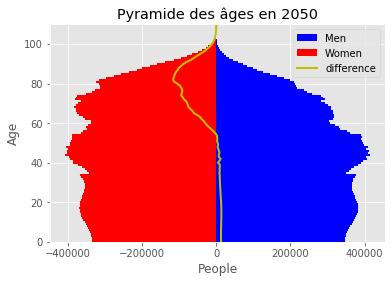

In [26]:
def iteration(pop, mortalite, fec, ratio):
    pop_next = pop * (1-mortalite)
    nais = naissances(pop, fec)
    row = numpy.array([[nais*ratio, nais*(1-ratio)]])
    pop_next = numpy.vstack([row, pop_next[:-1]]) # aucune naissance
    return pop_next

popt = pop
for year in range(2016, 2051):
    popt = iteration(popt, m, mat_fec, ratio)
                             
plot_population_pyramid(popt[:, 0], popt[:, 1], title="Pyramide des âges en 2050");

On va plus loin et on stocke la population dans un vecteur :

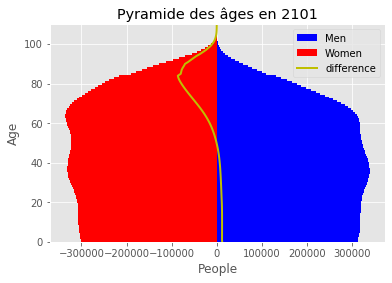

In [27]:
total = [[2015, pop[:,0].sum(),pop[:,1].sum()]]
popt = pop
for year in range(2016, 2101):
    popt = iteration(popt, m, mat_fec, ratio)
    total.append([year, popt[:,0].sum(),popt[:,1].sum()])
                             
plot_population_pyramid(popt[:, 0], popt[:, 1], title="Pyramide des âges en 2101");

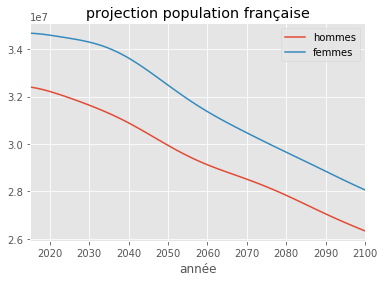

In [28]:
df = pandas.DataFrame(data=total, columns=["année","hommes","femmes"])
df.plot(x="année", y=["hommes", "femmes"], title="projection population française");

Le code suivant permet de combiner les deux graphes sur la même ligne avec la fonction [subplots](http://matplotlib.org/api/pyplot_api.html?highlight=subplots#matplotlib.pyplot.subplots) :

[comment]: <> (RST: .. index:: subplots)

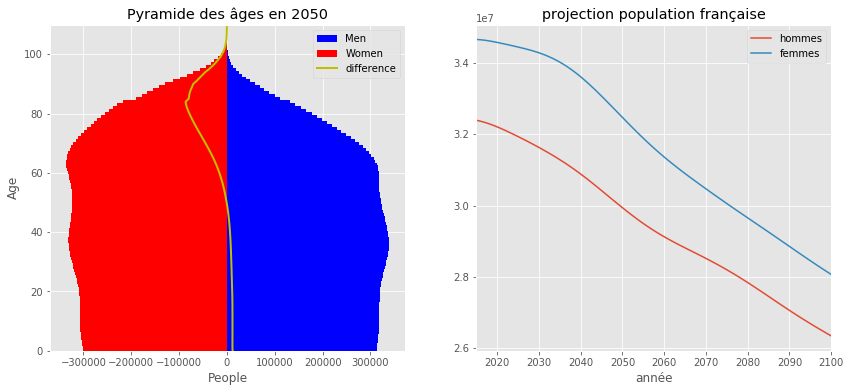

In [29]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14,6))
plot_population_pyramid(popt[:,0], popt[:,1], title="Pyramide des âges en 2050", ax=ax[0])
df.plot(x="année", y=["hommes", "femmes"], title="projection population française", ax=ax[1]);

### Autre représentation d'une pyramide avec le module pygal

Le code suivant utilise le module [pygal](http://pygal.org/) et le notebook [Interactive plots in IPython notebook using pygal](http://ino.pm/blog/ipython-pygal/#.VYM21kbrPtQ) ou celui-ci [pygal.ipynb
](https://github.com/yaph/ipython-notebooks/blob/master/pygal.ipynb).

In [30]:
from actuariat_python.data import population_france_year
population = population_france_year()
population.head(n=3)

,naissance,age,hommes,femmes,ensemble
0,2019,0,360058,346324,706382
1,2018,1,365656,350503,716159
2,2017,2,371835,357304,729139


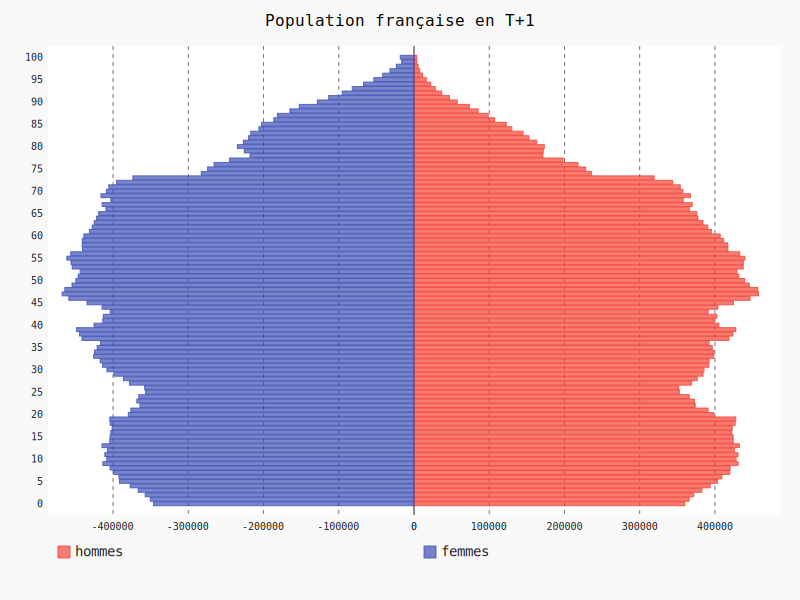

In [31]:
from IPython.display import SVG
import pygal
pyramid_chart = pygal.Pyramid(human_readable=True, legend_at_bottom=True)
pyramid_chart.title = 'Population française en T+1'
pyramid_chart.x_labels = map(lambda x: str(x) if not x % 5 else '', population["age"])
pyramid_chart.add("hommes", population["hommes"])
pyramid_chart.add("femmes", population["femmes"])
SVG(pyramid_chart.render())